In [1]:
%matplotlib inline

### Based on Cifar 10 implementation from https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

0it [00:00, ?it/s]

100%|█████████▉| 170319872/170498071 [01:35<00:00, 2230578.18it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


170500096it [01:50, 2230578.18it/s]                               

Let us show some of the training images, for fun.



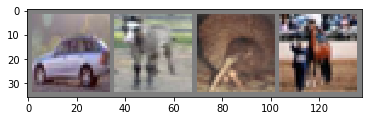

  car horse  bird horse


In [5]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

### Network Architecture

In [345]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

### Loss functions - CrossEntropy and Focal Loss

In [346]:
class CrossEntropy(nn.Module):
    def __init__(self):
        super(CrossEntropy, self).__init__()
        
    def _classProbs(self, inputs, targets):
        
        N,C = inputs.size()
        
        # for better numeric stability, shift all scores by max score
        max_scores,_ = torch.max(inputs, 1, keepdim=True)
        shiftedInputs = inputs - max_scores
        
        #calculate exp once
        expt = torch.exp(shiftedInputs)
        
        #class probabilities
        probs = expt/torch.sum(expt, dim=1, keepdim=True)
        
        #predicted class probabilities
        predicted_class_probs = probs[torch.arange(0, N, dtype=torch.uint8).tolist(),targets]
        return predicted_class_probs
    
    def forward(self, inputs, targets):
        
        #predicted class probabilities
        predicted_class_probs = self._classProbs(inputs, targets)
        
        # negative log loss - cross entropy
        loss = torch.mean(-torch.log(predicted_class_probs))
        return loss
    

#### Focal Loss as Described in paper https://arxiv.org/pdf/1708.02002.pdf

In [347]:
class FocalLoss(CrossEntropy):
    def __init__(self, gamma = 0):
        super(CrossEntropy, self).__init__()
        self._gamma = gamma
    
    def forward(self,inputs, targets):
        
        #predicted class probabilities
        predicted_class_probs = self._classProbs(inputs, targets)
        
        # weights - low weights for easy classses as 1-high prob ~ 0
        weights = (torch.ones_like(targets) - predicted_class_probs) ** self._gamma
        
        # weighted cross emtropy
        loss = torch.mean(weights * -torch.log(predicted_class_probs))
        return loss

In [325]:
netFocalLoss = Net()

# Select Focal Loss with gamma = 2
criterion = FocalLoss(2.)
optimizer = optim.SGD(netFocalLoss.parameters(), lr=0.001, momentum=0.9)

for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = netFocalLoss(inputs)
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 1.707
[1,  4000] loss: 1.261
[1,  6000] loss: 1.098
[1,  8000] loss: 1.047
[1, 10000] loss: 0.990
[1, 12000] loss: 0.950
[2,  2000] loss: 0.882
[2,  4000] loss: 0.865
[2,  6000] loss: 0.853
[2,  8000] loss: 0.848
[2, 10000] loss: 0.832
[2, 12000] loss: 0.820
Finished Training


In [348]:
netCrossEntropy = Net()

# Select Focal Loss with gamma = 2
criterion = CrossEntropy()
optimizer = optim.SGD(netCrossEntropy.parameters(), lr=0.001, momentum=0.9)

for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = netCrossEntropy(inputs)
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.176
[1,  4000] loss: 1.882
[1,  6000] loss: 1.674
[1,  8000] loss: 1.578
[1, 10000] loss: 1.486
[1, 12000] loss: 1.446
[2,  2000] loss: 1.383
[2,  4000] loss: 1.358
[2,  6000] loss: 1.319
[2,  8000] loss: 1.303
[2, 10000] loss: 1.260
[2, 12000] loss: 1.259
Finished Training


Let's quickly save our trained model:



In [326]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

See `here <https://pytorch.org/docs/stable/notes/serialization.html>`_
for more details on saving PyTorch models.

5. Test the network on the test data
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

We have trained the network for 2 passes over the training dataset.
But we need to check if the network has learnt anything at all.

We will check this by predicting the class label that the neural network
outputs, and checking it against the ground-truth. If the prediction is
correct, we add the sample to the list of correct predictions.

Okay, first step. Let us display an image from the test set to get familiar.



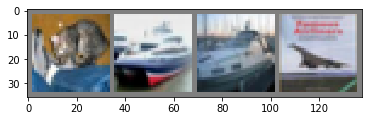

GroundTruth:    cat  ship  ship plane


In [327]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

Next, let's load back in our saved model (note: saving and re-loading the model
wasn't necessary here, we only did it to illustrate how to do so):



In [328]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

Okay, now let us see what the neural network thinks these examples above are:



In [329]:
outputs = net(images)

The outputs are energies for the 10 classes.
The higher the energy for a class, the more the network
thinks that the image is of the particular class.
So, let's get the index of the highest energy:



In [330]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:   ship  ship  ship  ship


The results seem pretty good.

Let us look at how the network performs on the whole dataset.



In [331]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 54 %


That looks way better than chance, which is 10% accuracy (randomly picking
a class out of 10 classes).
Seems like the network learnt something.

Hmmm, what are the classes that performed well, and the classes that did
not perform well:



In [15]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 41 %
Accuracy of   car : 50 %
Accuracy of  bird : 25 %
Accuracy of   cat : 32 %
Accuracy of  deer : 21 %
Accuracy of   dog : 35 %
Accuracy of  frog : 59 %
Accuracy of horse : 67 %
Accuracy of  ship : 63 %
Accuracy of truck : 62 %
